# Canny Edge Detection

Задача состоит в обнаружении границ на произвольном изображении с помощью детектора Кэнни.

Алгоритм состоит из 5 этапов:
1. Сглаживание.
2. Поиск градиентов: поиск значения и направления градиента.
3. Подавление немаксимумов.
4. Двойная пороговая фильтрация.
5. Трассировка области неоднозначности.




In [79]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

Для обнаружения границ необходимо полутоновое изображение.

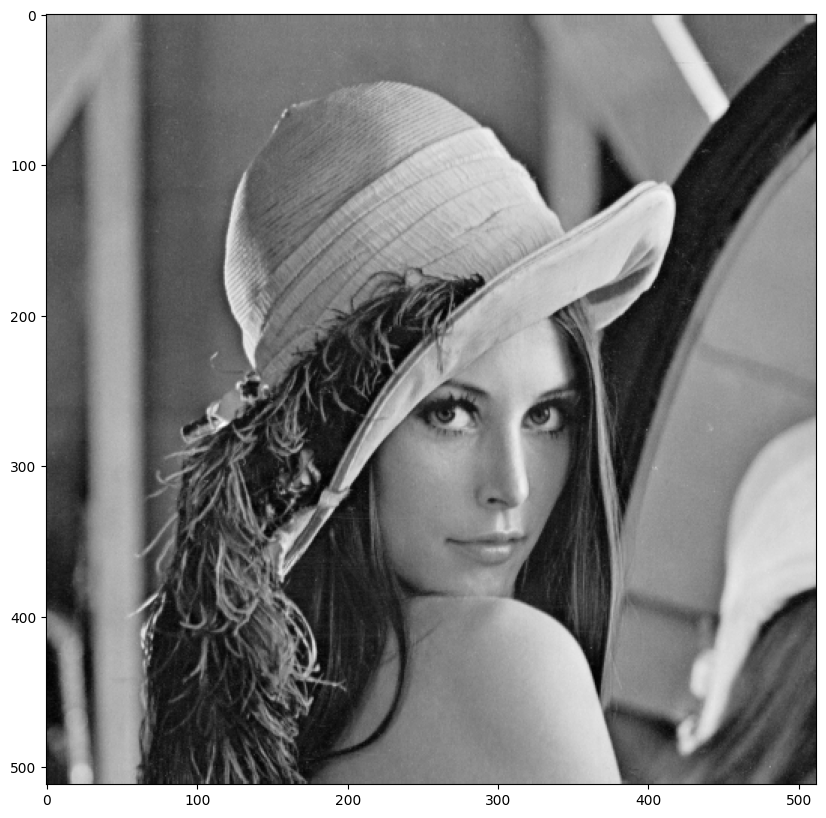

In [80]:
image = cv.imread("drive/MyDrive/cv_data/lena.tif")
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
plt.imshow(image, 'gray')

#1. Сглаживание
Необходимо выполнить размытие для устранения шума на изображении. Для этих целей можно использовать фильтр Гаусса (Gaussian filter kernel).

Ядро фильтра Гаусса размера (2k+1)×(2k+1) определяется как

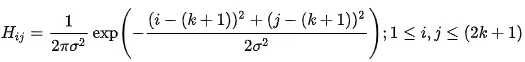



In [81]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) / (2.0 * np.pi * sigma**2)
    return g

Text(0.5, 1.0, 'sigma = 3')

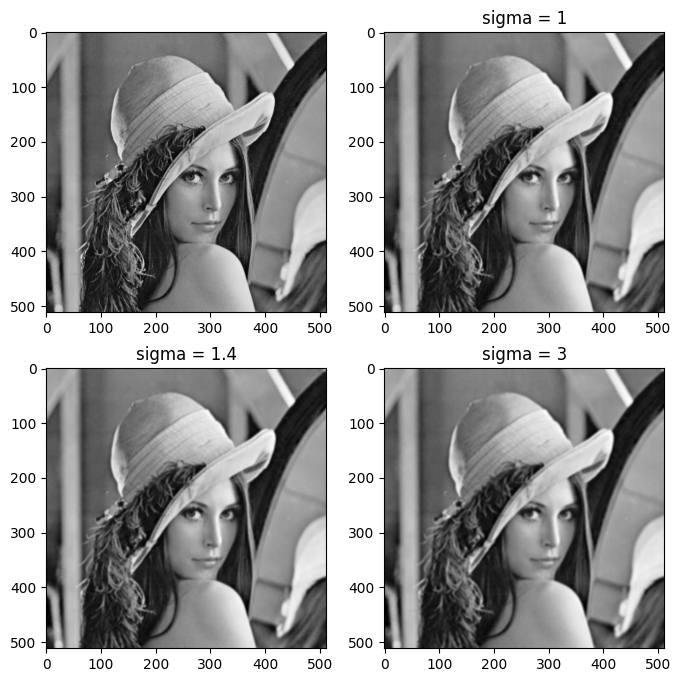

In [82]:
plt.rcParams['figure.figsize'] = [8, 8]
fig, axs = plt.subplots(2,2)
axs[0, 0].imshow(image, 'gray')
img_smoothed = cv.filter2D(src=image, ddepth=-1, kernel=gaussian_kernel(5, 1))
axs[0, 1].imshow(img_smoothed, 'gray')
axs[0, 1].set_title('sigma = 1')

img_smoothed = cv.filter2D(src=image, ddepth=-1, kernel=gaussian_kernel(5, 1.4))
axs[1, 0].imshow(img_smoothed, 'gray')
axs[1, 0].set_title('sigma = 1.4')

img_smoothed = cv.filter2D(src=image, ddepth=-1, kernel=gaussian_kernel(5, 3))
axs[1, 1].imshow(img_smoothed, 'gray')
axs[1, 1].set_title('sigma = 3')


#2. Поиск градиентов
Границы отмечаются там, где градиент изображения приобретает максимальное значение.

Используя фильтр Собеля, вычислим модуль градиента и направление градиента.

In [83]:
def sobel_filters(img):
    Hx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], np.float32)
    Gx = cv.filter2D(src=img, ddepth=-1, kernel=Hx)

    Hy = np.array([[ 1,  2,  1],
                   [ 0,  0,  0],
                   [-1, -2, -1]], np.float32)

    Gy = cv.filter2D(src=img, ddepth=-1, kernel=Hy)

    G = np.hypot(Gx, Gy)
    G = G / G.max() * 255
    theta = np.arctan2(Gy, Gx)

    return (G, theta)

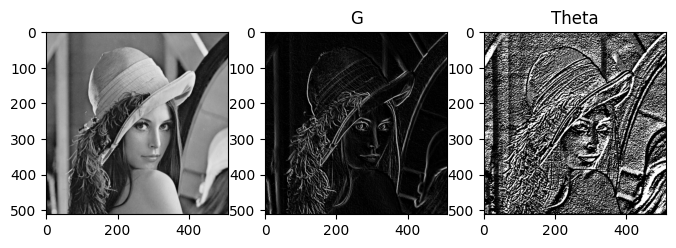

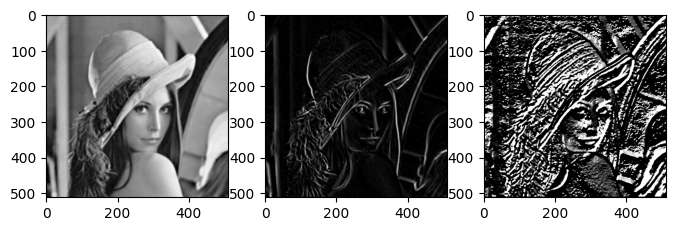

In [84]:
fig, axs = plt.subplots(1,3)
axs[0].imshow(image, 'gray')
G, theta = sobel_filters(image)
axs[1].imshow(G, 'gray')
axs[1].set_title('G')
axs[2].imshow(theta, 'gray')
axs[2].set_title('Theta')

fig, axs = plt.subplots(1,3)
axs[0].imshow(img_smoothed, 'gray')
G, theta = sobel_filters(img_smoothed)
axs[1].imshow(G, 'gray')
axs[2].imshow(theta, 'gray')


#3. Подавление немаксимумов
Выделение локальных максимумов.

Если пиксел имеет интенсивность менее, чем интенсивность пикселя в направлении градиента, то обнуляем значение.

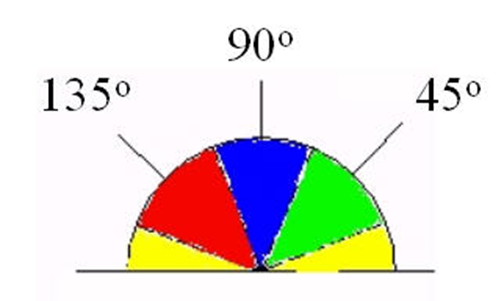

In [85]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                else: #elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass

    return Z

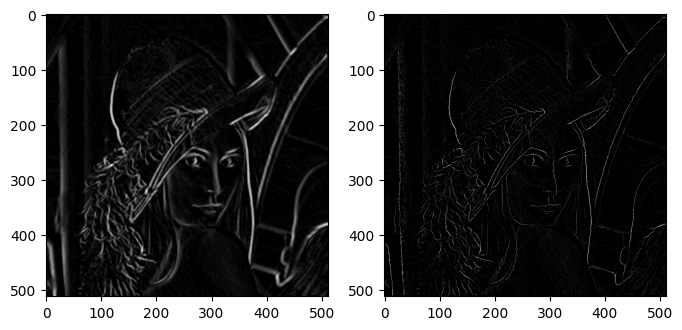

In [86]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(G, 'gray')
nonMaxImg = non_max_suppression(G, theta)
axs[1].imshow(nonMaxImg, 'gray')


#4. Двойная пороговая фильтрация
Потенциальные границы определяются порогами.

In [87]:
def threshold(img, lowThresholdRatio=0.09, highThresholdRatio=0.17, weak=125, strong=255):

    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res


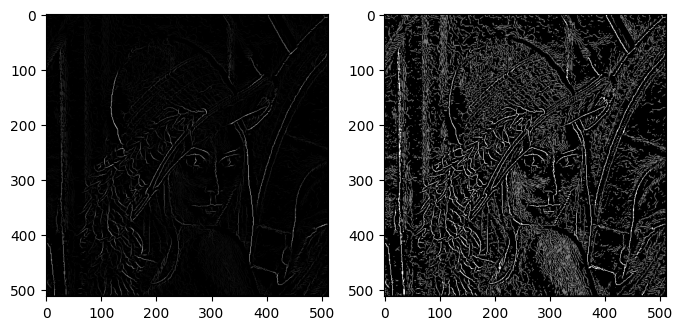

In [88]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(nonMaxImg, 'gray')
thresholdImg = threshold(nonMaxImg)
axs[1].imshow(thresholdImg, 'gray')

#5. Трассировка области неоднозначности
Если в окрестности "слабого" (weak) пикселя присутствует "сильный" (strong, тот, который уже классифицирован как граница), то "слабый" пиксель тоже классифицируется как граничный пиксель.

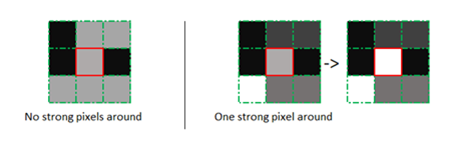


Сначала посмотрим, что из себя сейчас представляют "сильные" и "слабые" пиксели.

In [89]:
def strong_or_weak_edges(img, value=255):
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    strong_i, strong_j = np.where(img == value)
    res[strong_i, strong_j] = value

    return res

Text(0.5, 1.0, 'Weak')

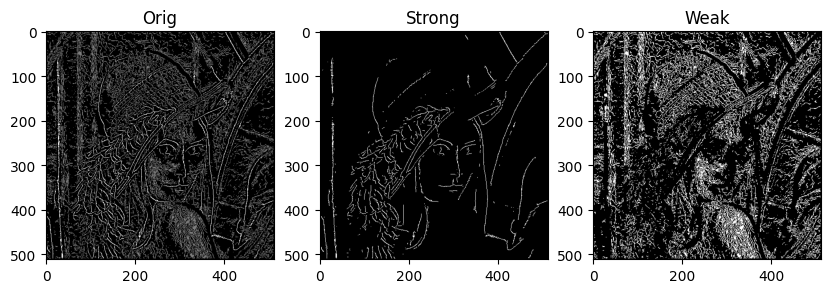

In [90]:
plt.rcParams['figure.figsize'] = [10, 10]

fig, axs = plt.subplots(1,3)
axs[0].imshow(thresholdImg, 'gray')
axs[0].set_title('Orig')

img_strong = strong_or_weak_edges(thresholdImg)
axs[1].imshow(img_strong, 'gray')
axs[1].set_title('Strong')

img_strong = strong_or_weak_edges(thresholdImg, 125)
axs[2].imshow(img_strong, 'gray')
axs[2].set_title('Weak')

In [91]:
def hysteresis(img, weak=125, strong=255):
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == strong):
              res[i, j] = strong
            elif (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        res[i, j] = strong
                    else:
                        res[i, j] = 0
                except IndexError as e:
                    pass
    return res

Text(0.5, 1.0, 'After hysteresis')

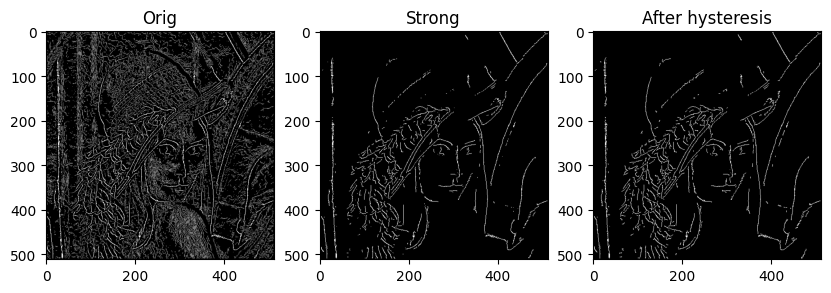

In [92]:
fig, axs = plt.subplots(1,3)
axs[0].imshow(thresholdImg, 'gray')
axs[0].set_title('Orig')

img_strong = strong_or_weak_edges(thresholdImg)
axs[1].imshow(img_strong, 'gray')
axs[1].set_title('Strong')

img_final = hysteresis(thresholdImg, 125)
axs[2].imshow(img_final, 'gray')
axs[2].set_title('After hysteresis')




---


Оформим шаги алгоритма в виде отдельной функции.
*  sigma – среднеквадратичное отклонение, параметр фильтра Гаусса,
*  kernel_size – размер ядра фильтра Гаусса,
*  lowthreshold – нижнее пороговое значение (относительное),
*  highthreshold – верхнее пороговое значение (относительное).

In [93]:
def cannyEdgeDetector(img, sigma=1.4, kernel_size=5, lowthreshold=0.09, highthreshold=0.17):
    weak_pixel = 125
    strong_pixel = 255
    img_smoothed = cv.filter2D(src=img, ddepth=-1, kernel=gaussian_kernel(kernel_size, sigma))
    gradientMat, thetaMat = sobel_filters(img_smoothed)
    nonMaxImg = non_max_suppression(gradientMat, thetaMat)
    thresholdImg = threshold(nonMaxImg, lowthreshold, highthreshold, weak_pixel, strong_pixel)
    img_final = hysteresis(thresholdImg, weak_pixel)
    return img_final


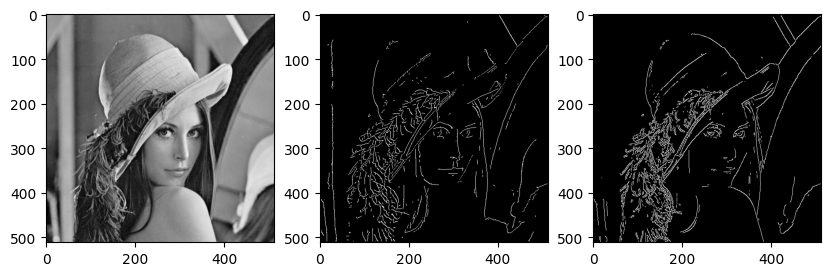

In [94]:
# image_file_name ="kodim08.png"
image_file_name ="lena.tif"

image = cv.imread("drive/MyDrive/cv_data/"+image_file_name)

image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
img_final = cannyEdgeDetector(image, sigma=1.4, kernel_size=5, lowthreshold=0.09, highthreshold=0.17)
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(image, 'gray')
ax2.imshow(img_final, 'gray')

edges = cv.Canny(image, threshold1=170, threshold2=200)
ax3.imshow(edges, 'gray')

```
void cv::Canny (
    InputArray 	image,
    OutputArray 	edges,
    double 	threshold1,
    double 	threshold2,
    int 	apertureSize = 3,
    bool 	L2gradient = false
)
```
*   **image**	8-bit input image.
*   **edges**	output edge map; single channels 8-bit image, which has the same size as image.
*   **threshold1** first threshold for the hysteresis procedure.
*   **threshold2** threshold2	second threshold for the hysteresis procedure.
*   **apertureSize** aperture size for the Sobel operator.
*   **L2gradient** a flag, indicating whether a more accurate L2 norm should be used to calculate the image gradient magnitude (`L2gradient=true`), or whether the default L1 norm is enough (`L2gradient=false`).